# Crop Disease Prediction


In [4]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 1. SETTINGS
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
EPOCHS = 15
DATA_DIR = "/kaggle/input/plantdisease/PlantVillage"

# 2. LOAD DATASET
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print("Classes:", class_names)

# 3. DATA AUGMENTATION (apply only to training data)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# 4. PREFETCH for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 5. BUILD MODEL (MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base

# Functional API Model Definition
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = layers.Rescaling(1./255)(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()






Found 20638 files belonging to 15 classes.
Using 16511 files for training.
Found 20638 files belonging to 15 classes.
Using 4127 files for validation.
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,423,887 (9.25 MB)

 Trainable params: 165,903 (648.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
# 6. TRAIN MODEL
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 216s 69ms/step - accuracy: 0.6174 - loss: 1.2069 - val_accuracy: 0.8471 - val_loss: 0.4502
Epoch 2/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.8393 - loss: 0.4852 - val_accuracy: 0.8563 - val_loss: 0.4113
Epoch 3/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.8688 - loss: 0.3834 - val_accuracy: 0.8835 - val_loss: 0.3361
Epoch 4/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.8880 - loss: 0.3252 - val_accuracy: 0.8757 - val_loss: 0.3713
Epoch 5/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.9046 - loss: 0.2778 - val_accuracy: 0.8740 - val_loss: 0.3670
Epoch 6/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.9141 - loss: 0.2505 - val_accuracy: 0.8861 - val_loss: 0.3323
Epoch 7/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.9206 - loss: 0.2248 - val_accuracy: 0.8948 - val_loss: 0.3161
Epoch 8/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.9277 - loss: 0.2037 -

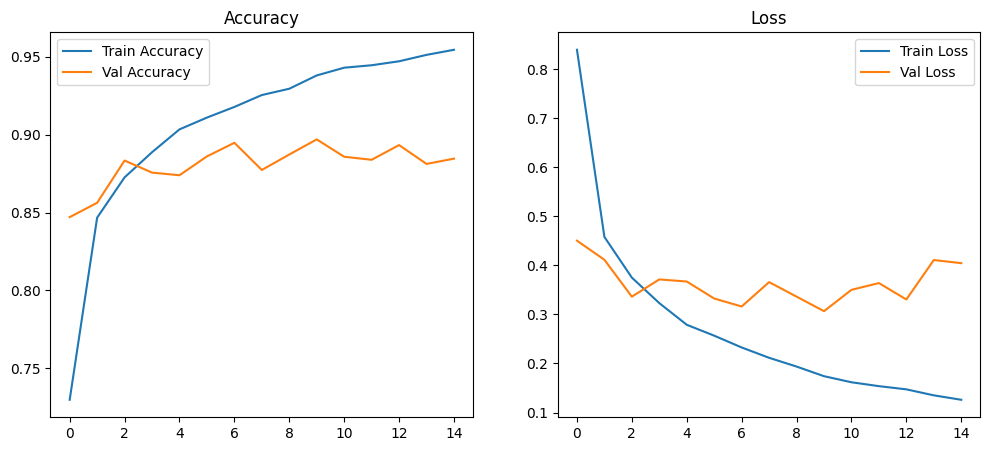

In [6]:

# 7. PLOT ACCURACY AND LOSS
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

plot_training(history)


In [ ]:
# 8. EVALUATE MODEL
y_true = []
y_pred = []

for images, labels in val_ds.unbatch():
    y_true.append(labels.numpy())
    img_batch = tf.expand_dims(images, 0)
    pred = model.predict(img_batch, verbose=0)
    y_pred.append(np.argmax(pred))


# 9. SAVE MODEL
model.save("crop_disease_model.h5")

NameError: name 'val_ds' is not defined